---
<div align="center">

# ML2 | Urban Sound Classification
</div>

---

<div align="center">
    
---
## Problem Formulation
---

</div>

### Context

Sound Classification is considered one of the most important tasks in the field of deep learning. It has great impact on applications of voice recognition within virtual assistants (Like Siri or Alexa), customer service as well as in music and media content recommendation systems.  Moreover, it also impacts the Medical field wheteher to detect abnormalities in heartbeats or repiratory sounds.In addition  it is also used within Security and Surveillance systems to help detect and assess a possible security breach inside a home whether it is infered by distress calls or even gunshots and glass breaking. Therefore, we aim to develop deep learning algorithms that can enable us to properly classify some environmental sounds provided by the UrbanSound8k Dataset.

Sound classification is one of the most important tasks in the field of deep learning, with significant impact on various applications. It plays a crucial role in voice recognition for virtual assistants like Siri and Alexa, enhances customer service interactions, and improves music and media content recommendation systems. Moreover, it has substantial applications in the medical field, such as detecting abnormalities in heartbeats or respiratory sounds. Additionally, sound classification is used in security and surveillance systems to detect and assess possible security breaches in homes, whether indicated by distress calls, gunshots, or glass breaking. 

### Resolution Approach

By utilizing the UrbanSound8k dataset as our primary data source, we intend to design deep learning models capable of reliably identifying, predicting, and evaluating various sounds common in urban settings which can support applications in noise monitoring, public safety, and environmental analysis, enabling precise assessment and response to auditory events in city environments.

### Planned Work

The project includes several key phases, including:

1. ``Exploratory Data Analysis`` : We begin by examining the UrbanSound8k dataset to gain deeper insights into its structure and content to helps us understand the distribution of sound classes.
2. ``Data pre-processing`` : Cleaning and Preparing the audio samples to ensure their consistency and quality over the .
3. ``Feature Engineering`` : Utilizing the Librosa library, we extract meaningful features from the audio data such as Mel-frequency cepstral coefficients (MFCCs).
4. ``Model architecture definition`` :  We develop the architecture of artificial neural networks tailored for sound classification. This involves experimenting with different deep learning models, such as Convolutional Neural Networks.
5. ``Training and Performance Evaluation`` : Employing the pre-partitioned dataset, we perform 10-fold cross-validation on each developed networks to then assess the models' performance using key metrics such as accuracy, precision, recall, F1-score, and confusion matrices.

<div align="center">
    
---
## Project Dependencies
---

</div>

In [1]:
# Remove ipykernel
# !jupyter kernelspec uninstall tf -y

In [2]:
# Add ipykernel
# !python -m ipykernel install --name "tensorflowKernel"

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\gongas\anaconda3\envs\tensorflow\lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# !pip install tensorflow_hub

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as libr
import ast

from sklearn.model_selection import (train_test_split)
from sklearn.preprocessing import (LabelEncoder)

import tensorflow as tf
from tensorflow.keras.utils import (to_categorical)
from tensorflow.keras import (layers, models)
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
import tensorflow_hub as hub

from Utils.Configuration import (loadConfig, loadPathsConfig)

from DataPreProcessing.AudioManagement import (loadAudio, showcaseAudio)
from DataPreProcessing.FeatureExtraction import (extractAllRawFeatures, extractRawFeatures1D, extractRawFeatures2D, processRawFeatures, extractMFCCs)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotFeatureDistributionByFold, plotAudioWave, plotAudio1DimensionalFeature, plotChromaFeatures, plotMelSpectrogram, plotSpectralContrast)

from ModelDevelopmentAndEvaluation.MLP import (MLP)
from ModelDevelopmentAndEvaluation.CNN import (CNN)
from ModelDevelopmentAndEvaluation.ResNet import (ResNet)
from ModelDevelopmentAndEvaluation.transferLearning import (createTransferLearning)
from ModelDevelopmentAndEvaluation.UrbanSound8kManager import (UrbanSound8kManager)
from ModelDevelopmentAndEvaluation.DataVisualization import (plotNetworkTrainingPerformance, plotScatterClass)

In [8]:
import sys
print(sys.executable)

C:\Users\Gongas\anaconda3\envs\Tensorflow\python.exe


In [9]:
# Load Configuration Dictionaries
config = loadConfig()
pathsConfig = loadPathsConfig()
config

{'DURATION': 4,
 'SAMPLE_RATE': 44100,
 'HOP_LENGTH': 551,
 'WINDOW_LENGTH': 1014,
 'N_FFT': 1024,
 'TIME_SIZE': 321,
 'N_CHROMA': 12,
 'N_MFCC': 13}

<div align="center">
    
---
## Exploratory Data Analysis
---

</div>

> PLAY AROUND WITH THE DATA

In [10]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

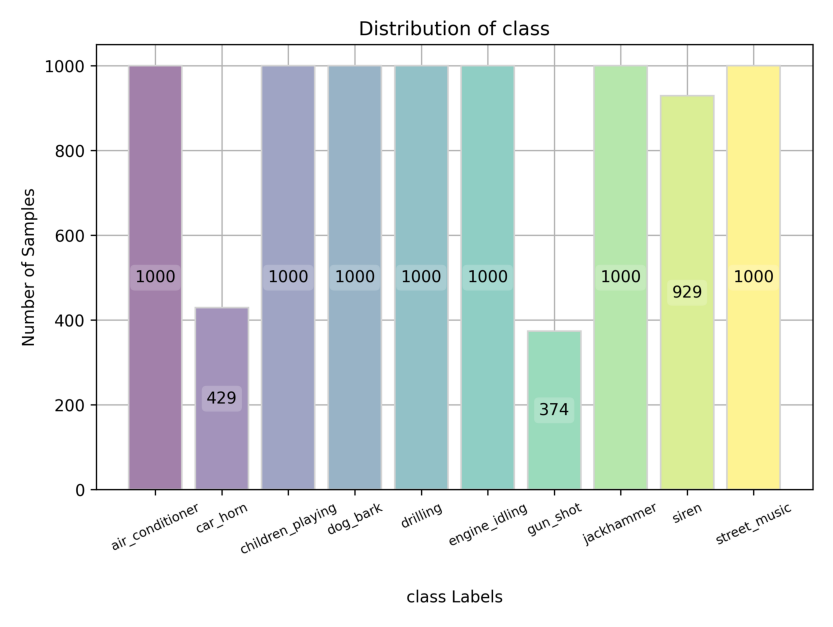

In [11]:
# Plot the distribution of the target class
plotFeatureDistribution(df=df, classFeature='class', pathsConfig=pathsConfig)

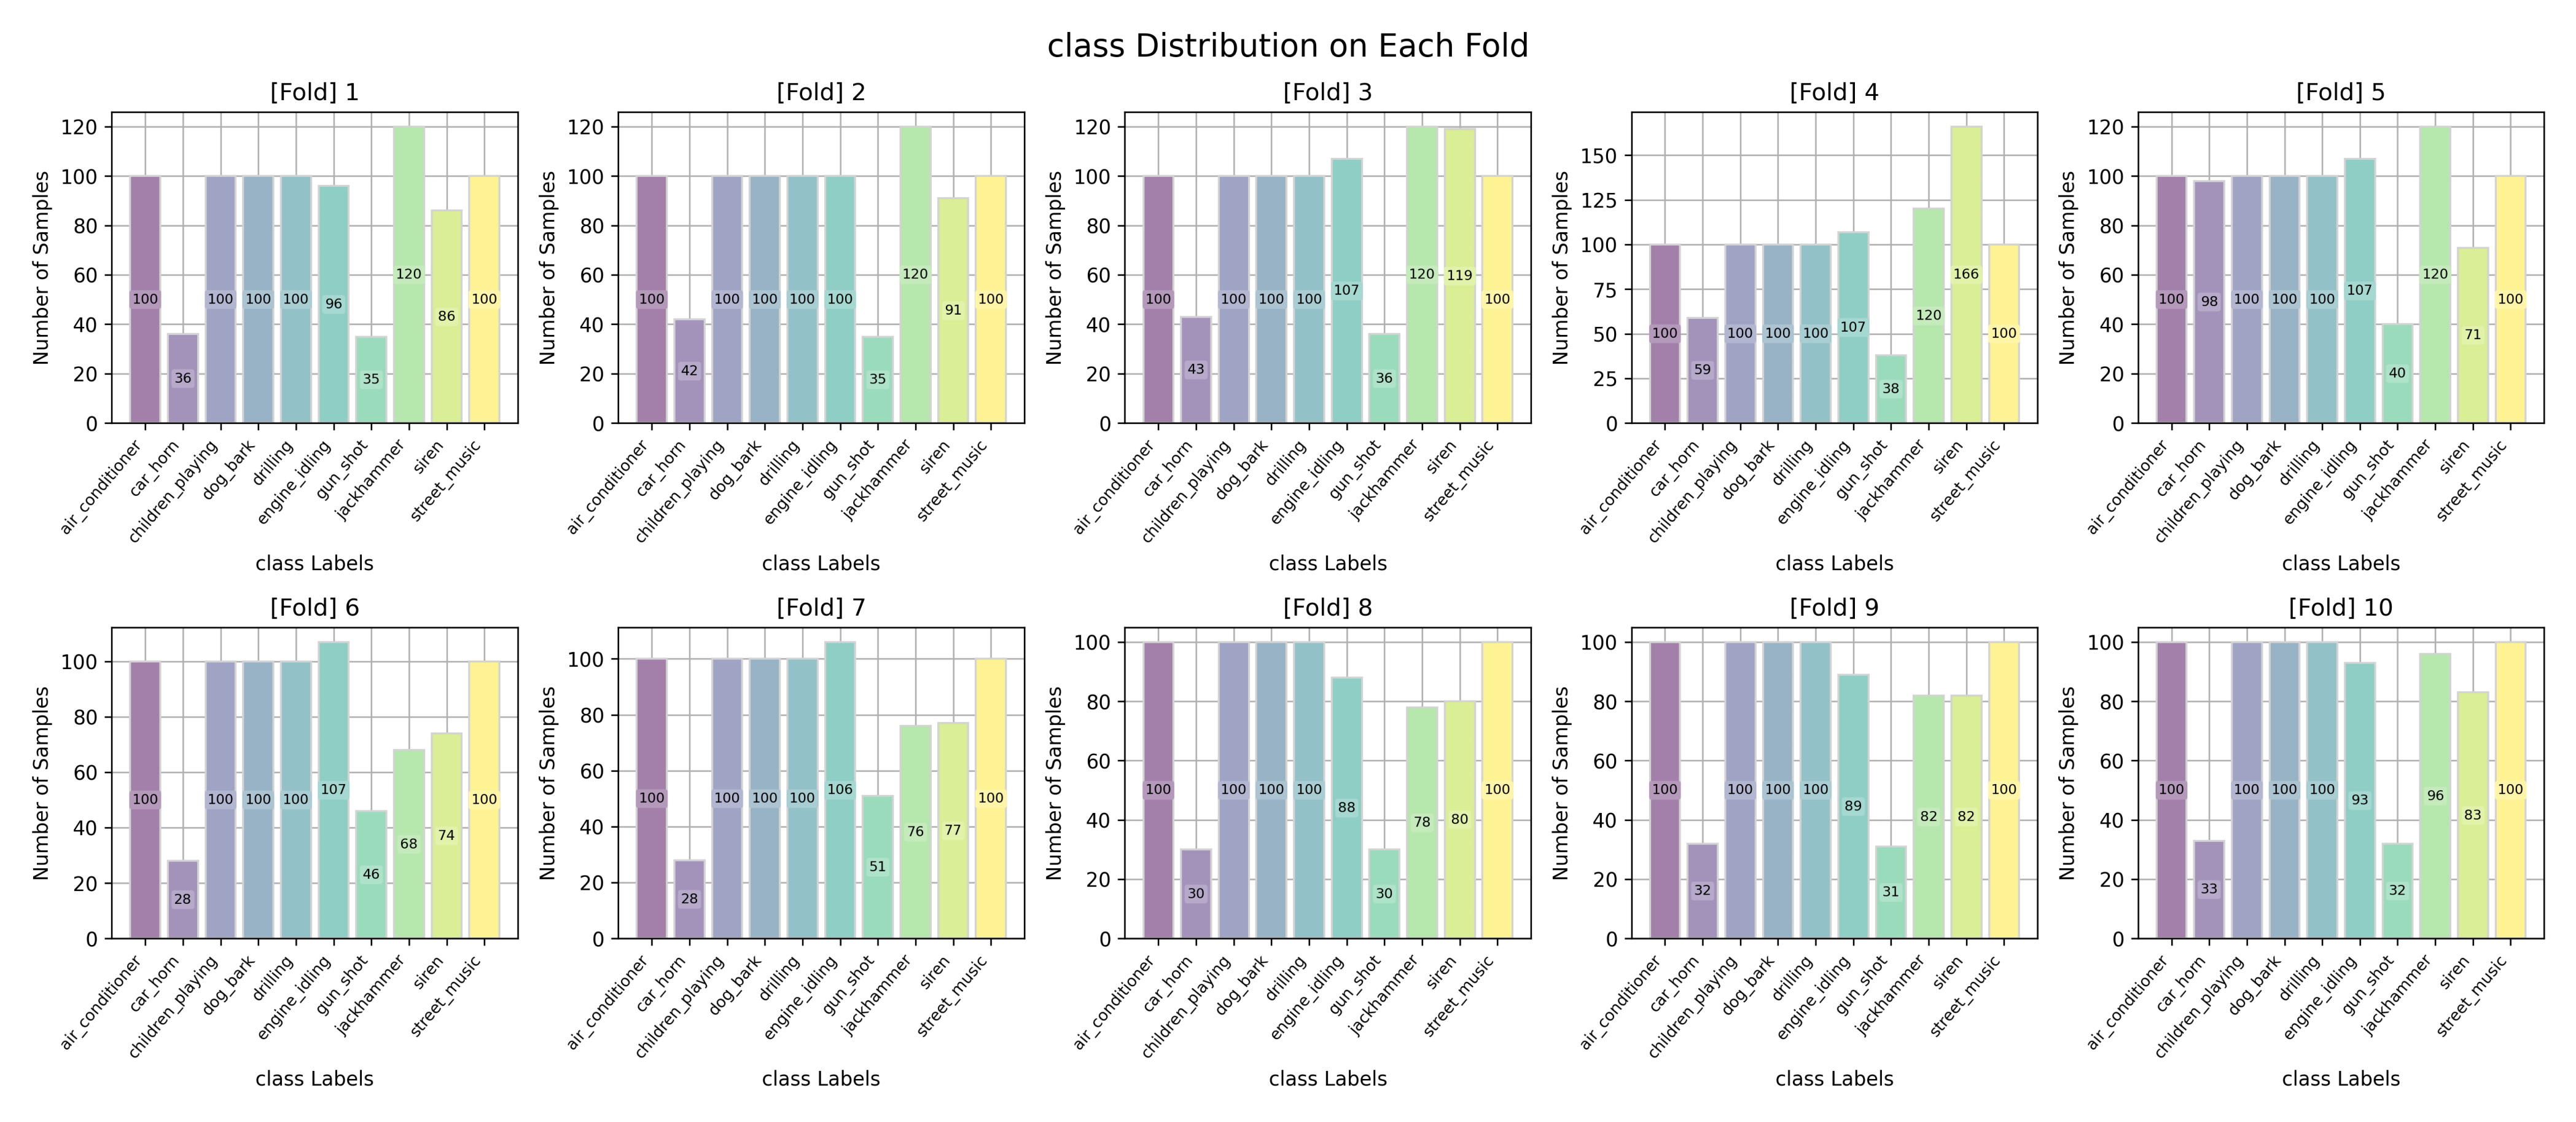

In [12]:
# Plot the class distribution per fold
plotFeatureDistributionByFold(df=df, classFeature='class', foldFeature='fold', pathsConfig=pathsConfig)

<div align="center">
    
---
## Data Preprocessing
---

</div>

> EXTRACT THE IMPORTANT FEATURES FROM THE AUDIO SAMPLES


In this initial phase, we aim to 

---
### Sound Features
---

To accurately analyze and extract features from audio samples, we first need to load them properly. Using the librosa library, we can handle each audio file from the dataset with careful consideration of duration, sample rate, and zero-padding.

The target length is calculated as the product of the DURATION (4 seconds, as specified in the dataset) and the TARGET_SAMPLE_RATE.

We opted to increase the sample rate from the default 22,050 Hz to 44,100 Hz to capture higher-quality details, given the variety of sounds in the dataset — ranging from complex audio like street music to simpler noises like car horns. 

Consequently, zero-padding will ensure that all audio samples remain with a consistent length, standardizing the dataset for more reliable feature extraction. Moreover, this size consistency is crucial when training deep learning models, since they require a uniform input size across all samples.

In [13]:
# Load a audio
audioName = '101415-3-0-2.wav'
audioData = loadAudio(df_audio=df, audioSliceName=audioName, audioDuration=config['DURATION'], targetSampleRate=config['SAMPLE_RATE'], usePadding=True)
audioData.shape

(176400,)

In [14]:
# Show the audio associated with the selected file
showcaseAudio(df_audio=df, audioSliceName=audioName)

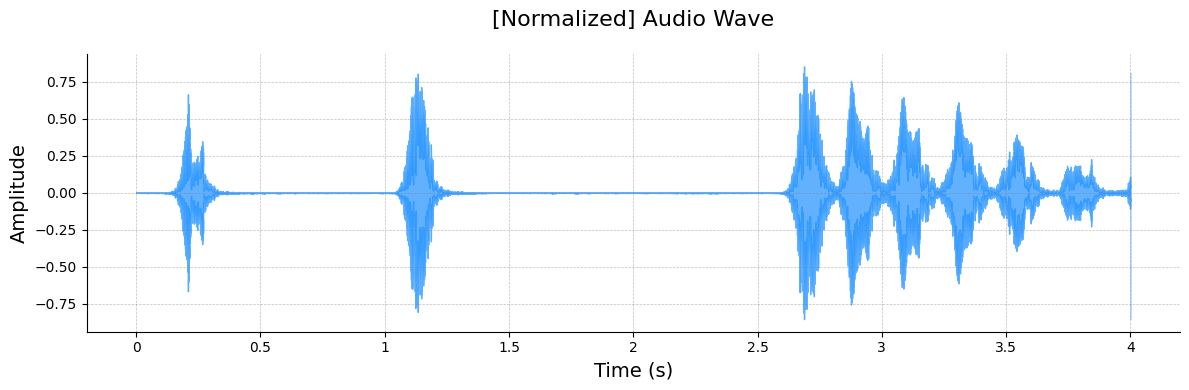

In [15]:
# Plot the Audio Wave
plotAudioWave(df_audio=df, audioSliceName=audioName, config=config)

---
### 1-Dimensional Features
---

#### &rarr; Zero-Crossing Rate (ZCR)

``Description`` : ZCR measures how often the signal changes sign (crosses zero) in a frame.

This is a time-domain feature that is particularly useful for distinguishing between different types of noise or impulsive sounds, such as car horns or dog barks, which have different temporal behaviors.

In [16]:
# Compute the Audio's Zero Crossing Rate
zeroCrossingRate = libr.feature.zero_crossing_rate(y=audioData)
print(zeroCrossingRate.shape)
# zeroCrossingRate

(1, 345)


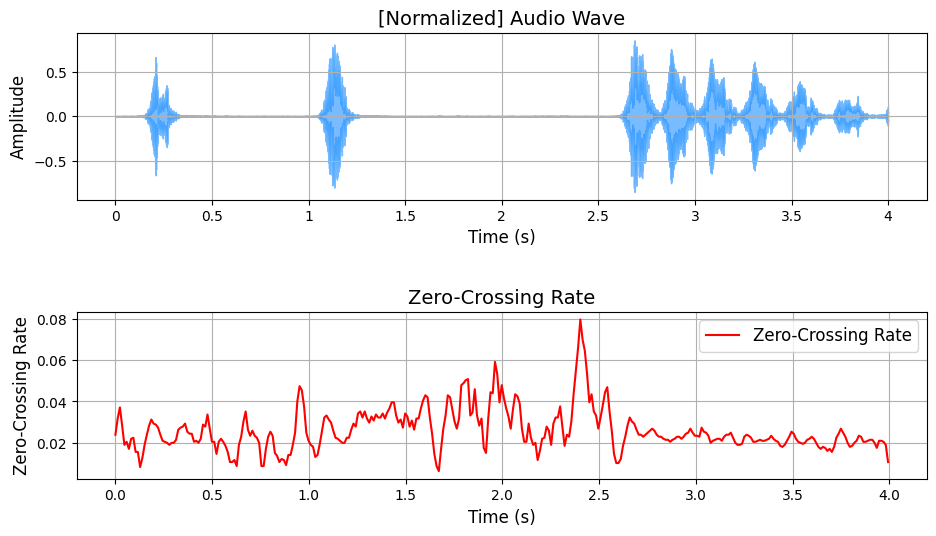

In [17]:
# Plot the Audio's Zero-Crossing Rate
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=zeroCrossingRate, featureName='Zero-Crossing Rate', yLabel='Zero-Crossing Rate', color='r', config=config)

#### &rarr; Spectral Centroid

``Description`` : The spectral centroid is the "center of mass" of the spectrum, giving an indication of where the energy of the sound is concentrated.

It helps in distinguishing between sounds with different frequency content (e.g., high-pitched sirens vs. low-pitched engine noises).

In [18]:
# Compute the Audio's Spectral Centroid
spectralCentroid = libr.feature.spectral_centroid(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralCentroid.shape)
# spectralCentroid

(1, 345)


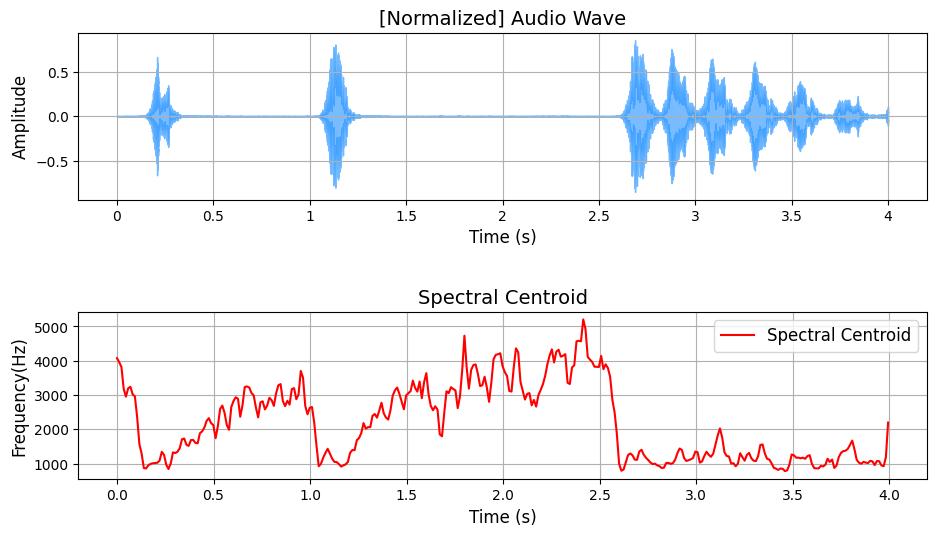

In [19]:
# Plot the Audio's Spectral Centroid
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralCentroid, featureName='Spectral Centroid', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Bandwidth

``Description`` : This measures the width of the spectrum (the difference between the lower and upper frequencies in a sound).

It helps distinguish sounds with wide frequency content (e.g., crowd noise) from those with narrow frequency content (e.g., beeps or alarms).

In [20]:
# Compute the Audio's Spectral Bandwidth
spectralBandwidth = libr.feature.spectral_bandwidth(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralBandwidth.shape)
# spectralBandwidth

(1, 345)


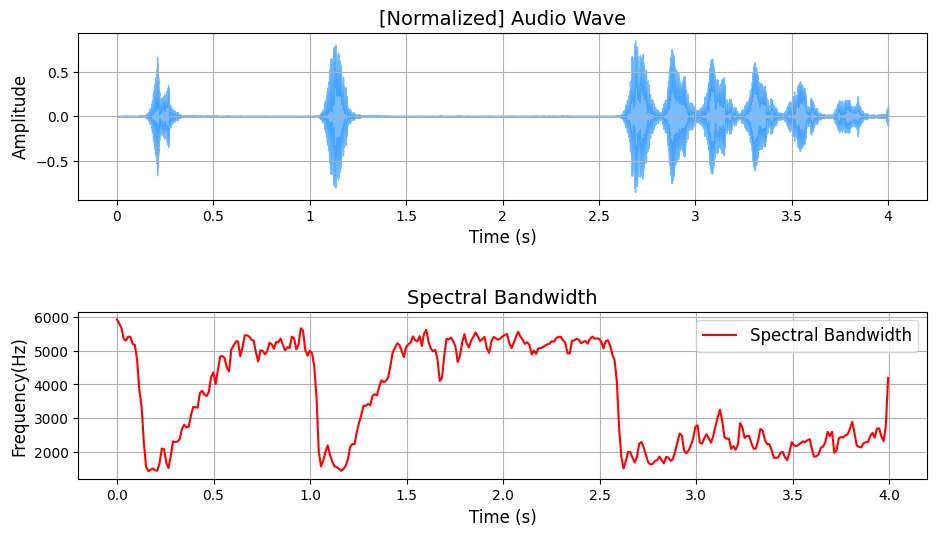

In [21]:
# Plot the Audio's Spectral Bandwidth
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralBandwidth, featureName='Spectral Bandwidth', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Flatness

``Description`` : Measures how noise-like or tonal a sound is by comparing the geometric and arithmetic means of the power spectrum.

Helps distinguish between tonal sounds (e.g., sirens, horns) and noise-like sounds (e.g., wind, traffic).

In [22]:
# Compute the Audio's Spectral Flatness
spectralFlatness = libr.feature.spectral_flatness(y=audioData)
print(spectralFlatness.shape)
# spectralFlatness

(1, 345)


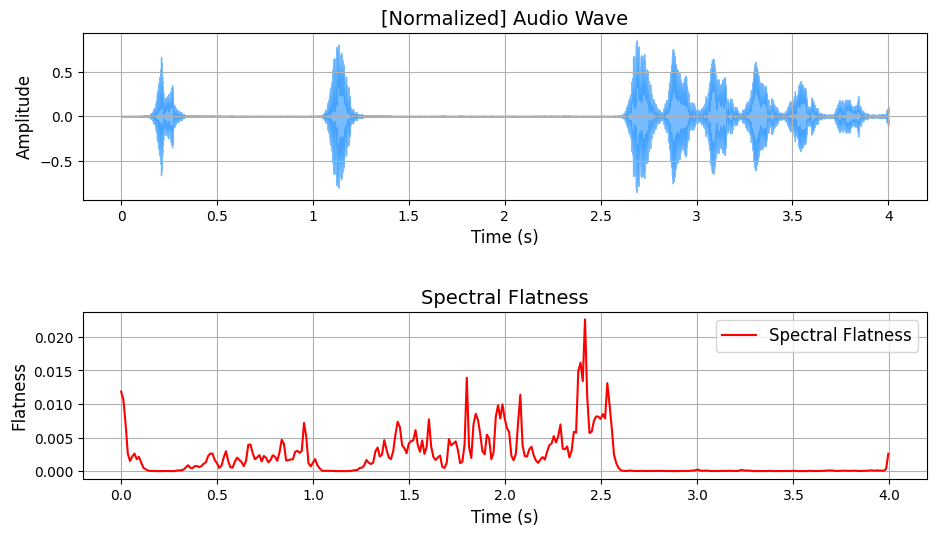

In [23]:
# Plot the Audio's Spectral Flatness
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralFlatness, featureName='Spectral Flatness', yLabel='Flatness', color='r', config=config)

#### &rarr; Spectral Roll-off

``Description`` : Spectral roll-off is the frequency below which a specified percentage (usually 85-90%) of the total spectral energy is contained.

It helps differentiate between high-frequency sounds (e.g., sharp noises like sirens or alarms) and low-frequency sounds (e.g., engine noise, rumbling).

In [24]:
# Compute the Audio's Spectral Roll-off
spectralRolloff = libr.feature.spectral_rolloff(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralRolloff.shape)
# spectralRolloff

(1, 345)


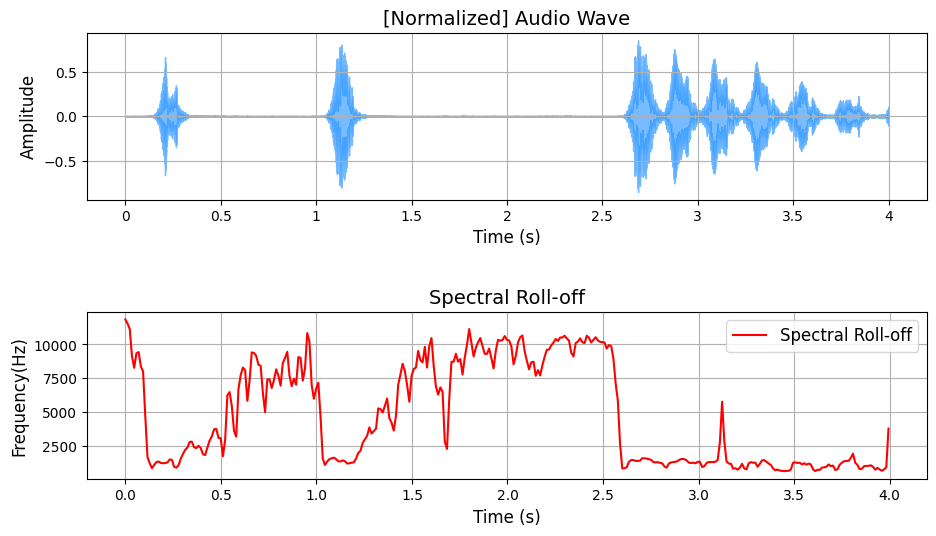

In [25]:
# Plot the Audio's Spectrall Roll-off
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralRolloff, featureName='Spectral Roll-off', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; RMS Energy

``Description`` : The Root Mean Square (RMS) energy is a measure of the signal's energy over time.

It is useful to distinguish between quiet and loud sounds and can help classify sounds with varying intensity, such as traffic or construction noise.

In [26]:
# Compute the Audio's RMS Energy
rms = libr.feature.rms(y=audioData)
print(rms.shape)
# rms

(1, 345)


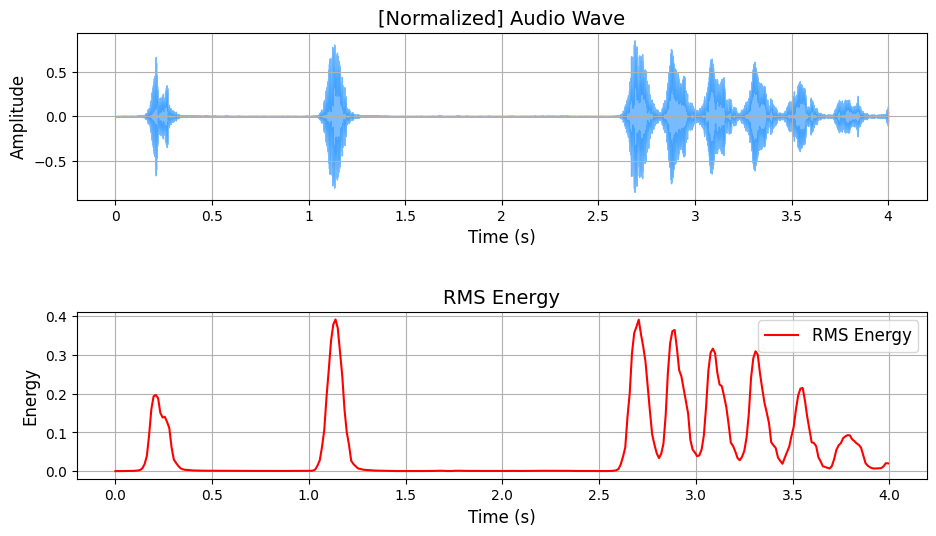

In [27]:
# Plot the Audio's RMS Energy
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=rms, featureName='RMS Energy', yLabel='Energy', color='r', config=config)

---
### 2-Dimensional Features
---

#### &rarr; Mel-Frequency Cepstral Coefficients (MFCC)

``Description`` : MFCCs represent the short-term power spectrum of an audio signal, emphasizing the perceptually relevant features for human hearing.

MFCCs are widely used in audio classification tasks, including speech recognition and environmental sound classification. They effectively capture the timbral texture of sounds, which is important for distinguishing different urban sound categories.

In [28]:
# Compute the MFC Coefficients
mfccs = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], n_mfcc=config['N_MFCC'])
print(mfccs.shape)
# mfccs

(13, 345)


#### &rarr; Chroma Features (Chroma STFT)

``Description`` : Chroma features represent the pitch class (e.g., C, C#, D, etc.) and are useful for identifying tonal and harmonic content in audio.

While chroma features are traditionally more useful for music, they can capture harmonic structure in urban sounds, especially those with tonal elements like sirens or honking.

In [29]:
# Compute the Chroma Features
chroma_stft = libr.feature.chroma_stft(y=audioData, n_chroma=config['N_CHROMA'], sr=config['SAMPLE_RATE'], n_fft=config['N_FFT'], hop_length=config['HOP_LENGTH'], win_length=config['WINDOW_LENGTH'])
print(chroma_stft.shape)
# chroma_stft

(12, 321)


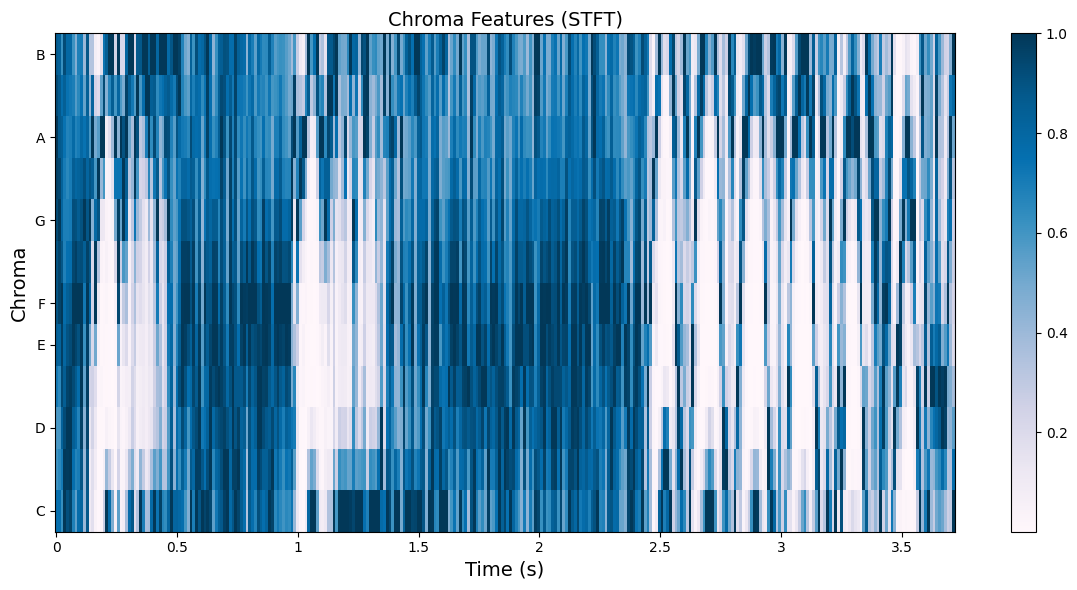

In [30]:
# Plot the audio's Chroma Features
plotChromaFeatures(audioData=audioData, config=config)

#### &rarr; Mel Spectrogram

``Description`` : A Mel spectrogram is a representation of the signal's power across different frequencies, scaled to the Mel scale (which mimics human auditory perception).

It is particularly useful for capturing the overall energy and frequency distribution of urban sounds. It’s a more detailed version of MFCCs, emphasizing the full frequency range.

In [31]:
# Compute the Mel Spectrogram
melSpectrogram = libr.feature.melspectrogram(y=audioData, sr=config['SAMPLE_RATE'])
print(melSpectrogram.shape)
# melSpectrogram

(128, 345)


In [32]:
np.mean(melSpectrogram, axis=1).shape

(128,)

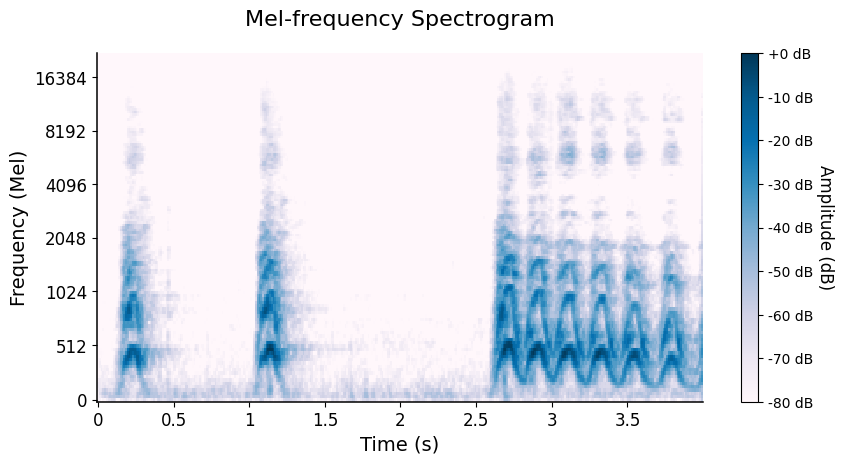

In [33]:
# Plot the Mel Spectrogram
plotMelSpectrogram(audioData, config['SAMPLE_RATE'])

#### &rarr; Spectral Contrast

``Description`` : Spectral contrast measures the difference between peaks and valleys in the sound spectrum.

Urban sounds tend to have diverse spectral profiles (e.g., the contrast between loud car horns and quieter ambient sounds), making spectral contrast useful for distinguishing between classes.

In [34]:
# Compute the Spectral Contrast
spectralContrast = libr.feature.spectral_contrast(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralContrast.shape)
# spectralContrast

(7, 345)


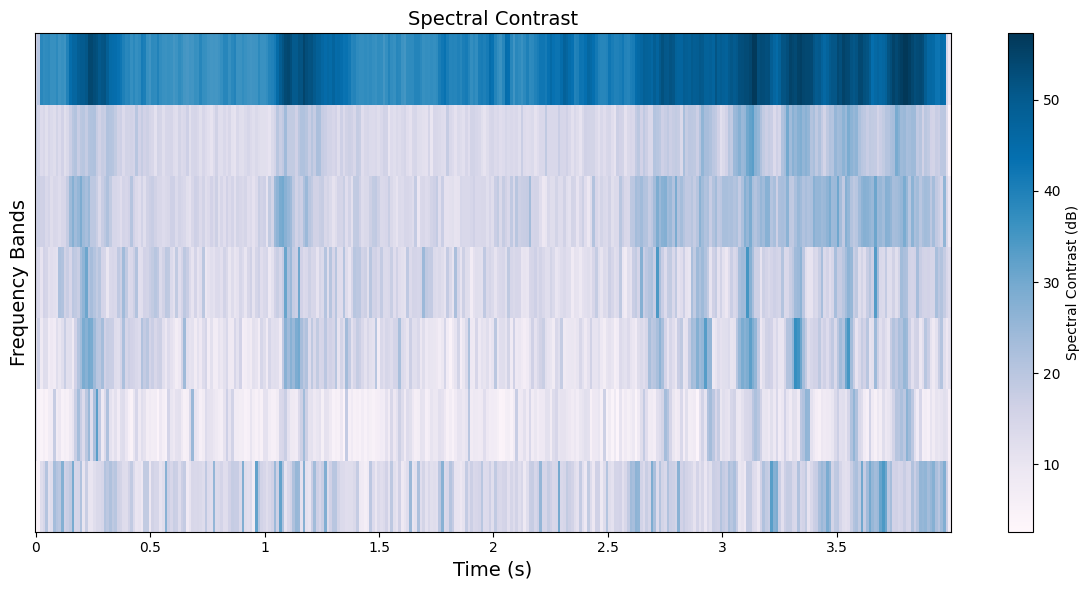

In [35]:
# Plot the Audio's Spectral Contrast
plotSpectralContrast(audioData=audioData, config=config)

---
## Data Pre-Processing and Preparation
---

> PERFORM DATA PREPROCESSING AND PREPARATION

In [36]:
# Extract all the 1-Dimensional and 2-Dimensional Features on each Fold
for fold in range(1, 11):

    print(f"[CURRENT] Fold {fold}")
    
    # Extract all Raw Features
    extractAllRawFeatures(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)

    # Extract and process 1-Dimensional Features
    extractRawFeatures1D(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    processRawFeatures(fold=fold, intervalStep=20, featuresDimensionality="1D", pathsConfig=pathsConfig)
    
    # Extract and process 2-Dimensional Features
    extractRawFeatures2D(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    processRawFeatures(fold=fold, intervalStep=20, featuresDimensionality="2D", pathsConfig=pathsConfig)

    # Extract the MFCCs (Raw and their mean based on the coefficients)
    extractMFCCs(audio_df=df, raw=True, fold=fold, config=config, pathsConfig=pathsConfig)
    extractMFCCs(audio_df=df, raw=False, fold=fold, config=config, pathsConfig=pathsConfig)

    # print(f"[Fold {fold}] Finished Extraction and Processment")

[CURRENT] Fold 1
[CURRENT] Fold 2
[CURRENT] Fold 3
[CURRENT] Fold 4
[CURRENT] Fold 5
[CURRENT] Fold 6
[CURRENT] Fold 7
[CURRENT] Fold 8
[CURRENT] Fold 9
[CURRENT] Fold 10


<div align="center">
    
---
## Model Architecture Definition
---

</div>

> ADD MODEL ARCHITECTURE DEFINITION

---
### Managing Training Data
---

> DEFINE THE NETWORK ARCHITECTURE

---
### Multi-Layered Perceptron (MLP)
---

> DEFINE THE NETWORK ARCHITECTURE

In [37]:
# Load the Dataset with the 1-Dimensional Extracted Data
mlpDataManager = UrbanSound8kManager(dataDimensionality='1D', modelType="MLP", testNumber=1, pathsConfig=pathsConfig)

In [38]:
def createMLP():
    # Create a instance of the network
    mlp = MLP()
    mlpModel = mlp.createMLP(input_shape=(255,))

    # Define the learning rate to use
    lr = 0.001
    
    # Define the Optimizer
    optimizer = Adam(learning_rate=lr)
    
    # Compile the model
    mlpModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Return Compiled Model
    return mlpModel

In [39]:
# Create a instance of the MLP and inspect its architecture
mlpModel = createMLP()
mlpModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 80)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80)                  │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           3,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             820 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             210 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,310 (98.87 KB)

 Trainable params: 25,030 (97.77 KB)

 Non-trainable params: 280 (1.09 KB)

In [40]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


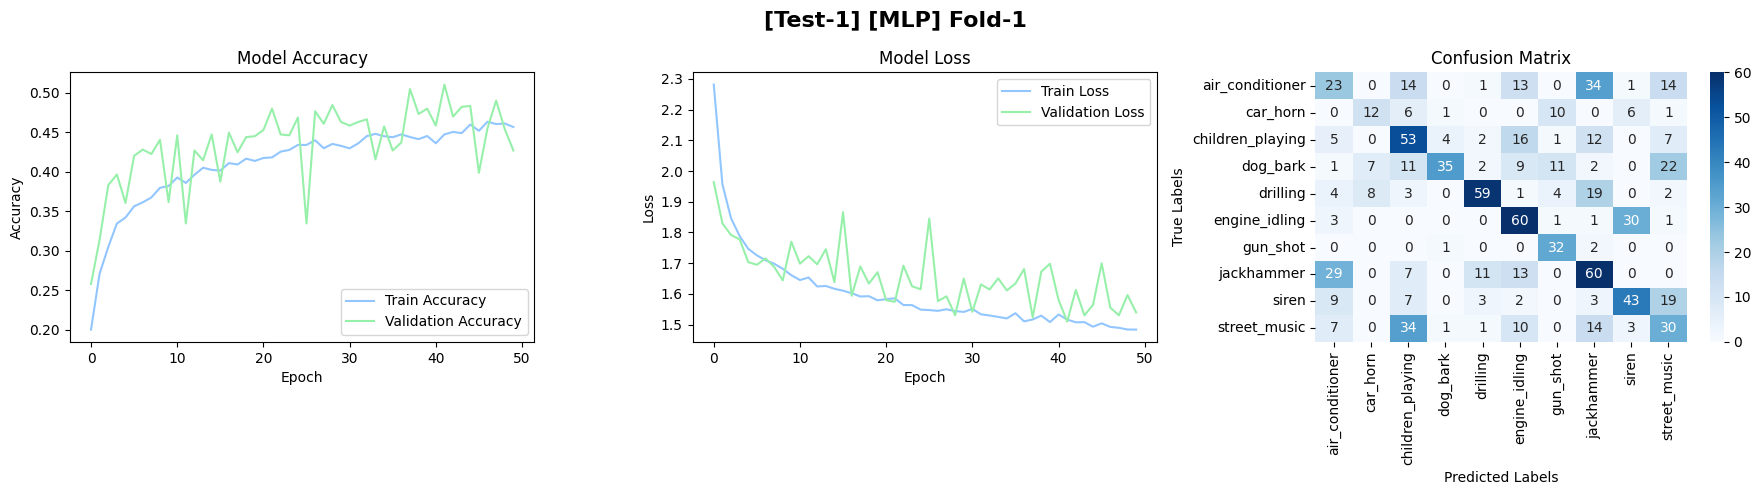

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


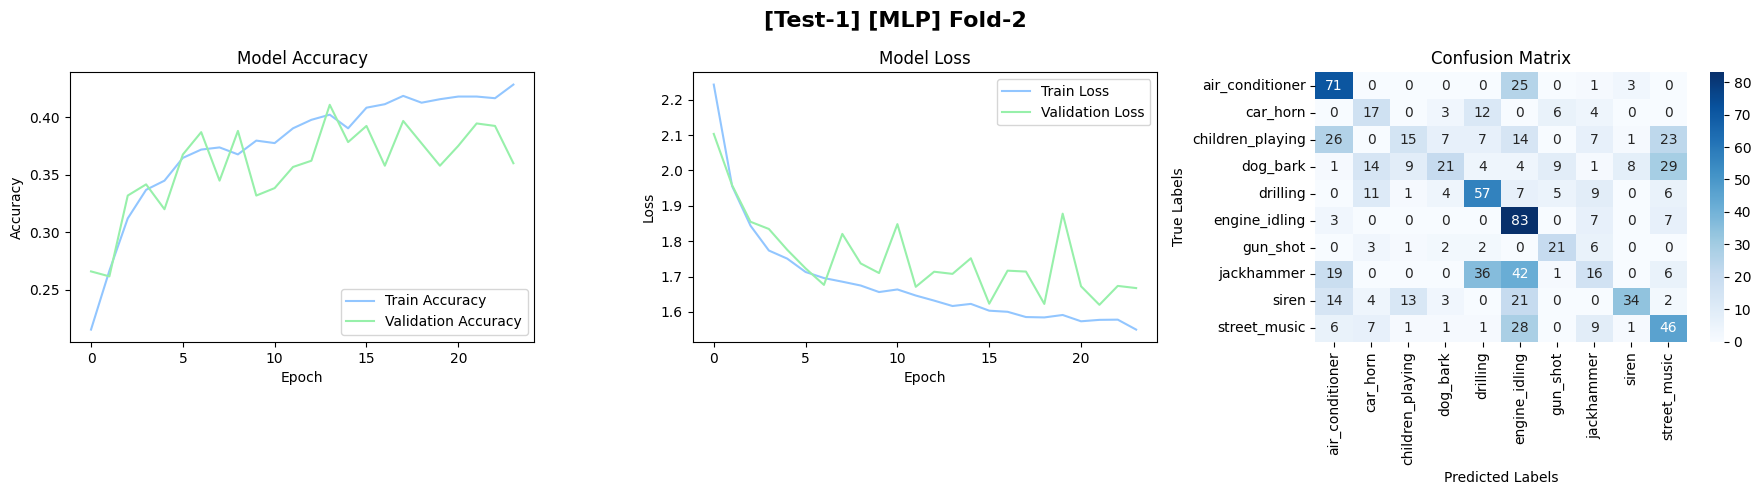

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


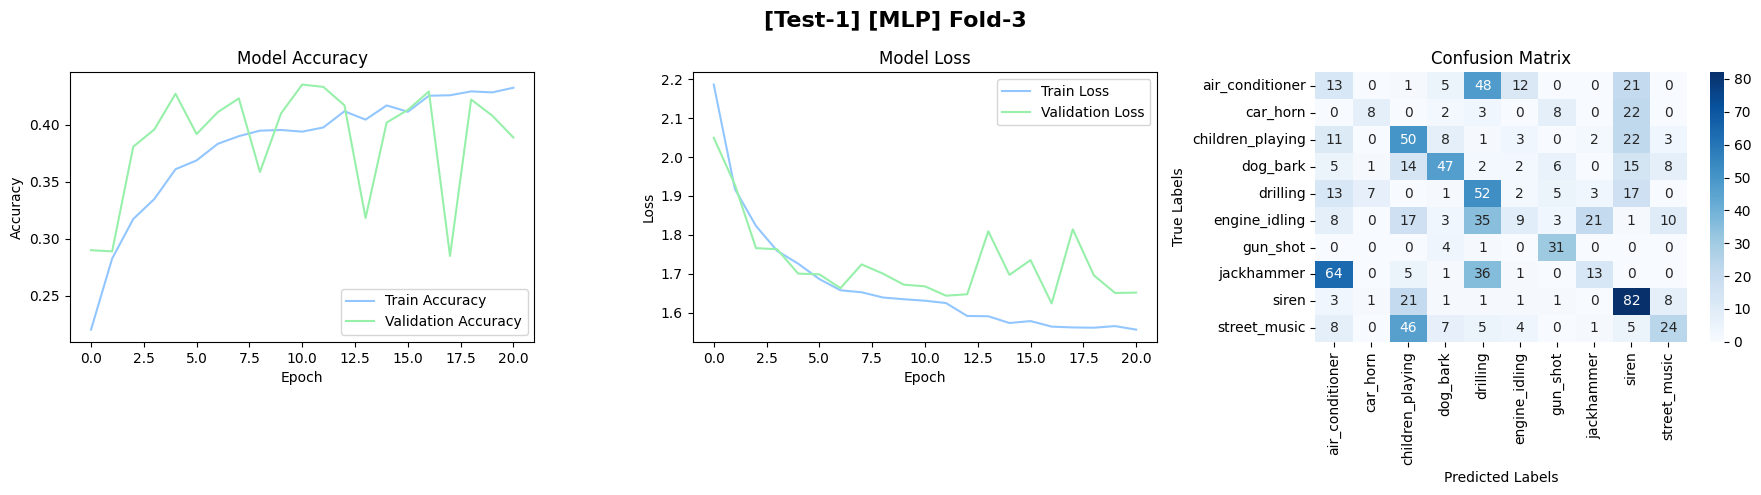

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


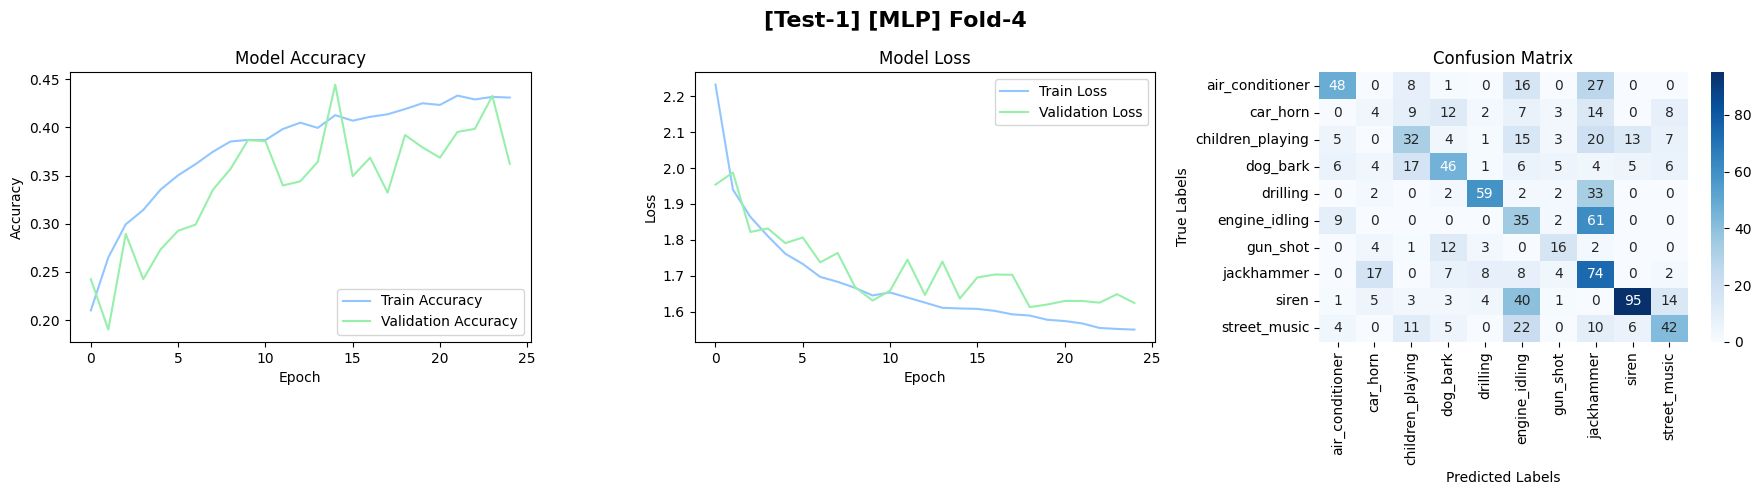

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


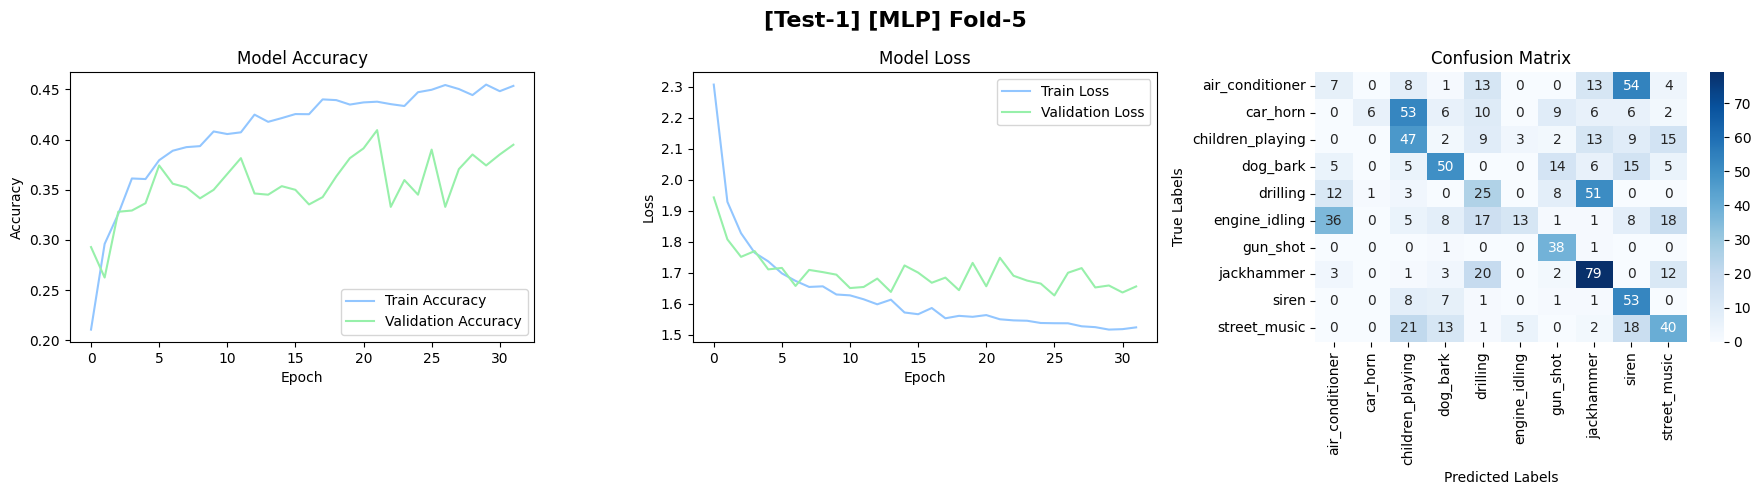

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


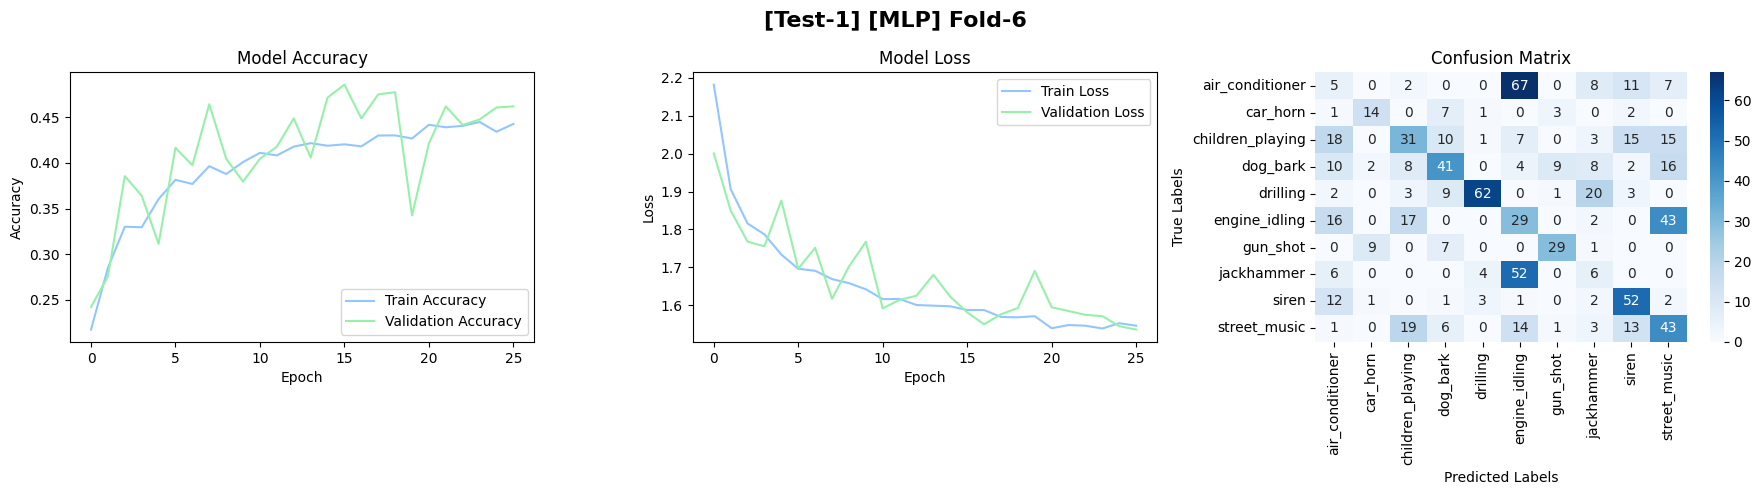

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


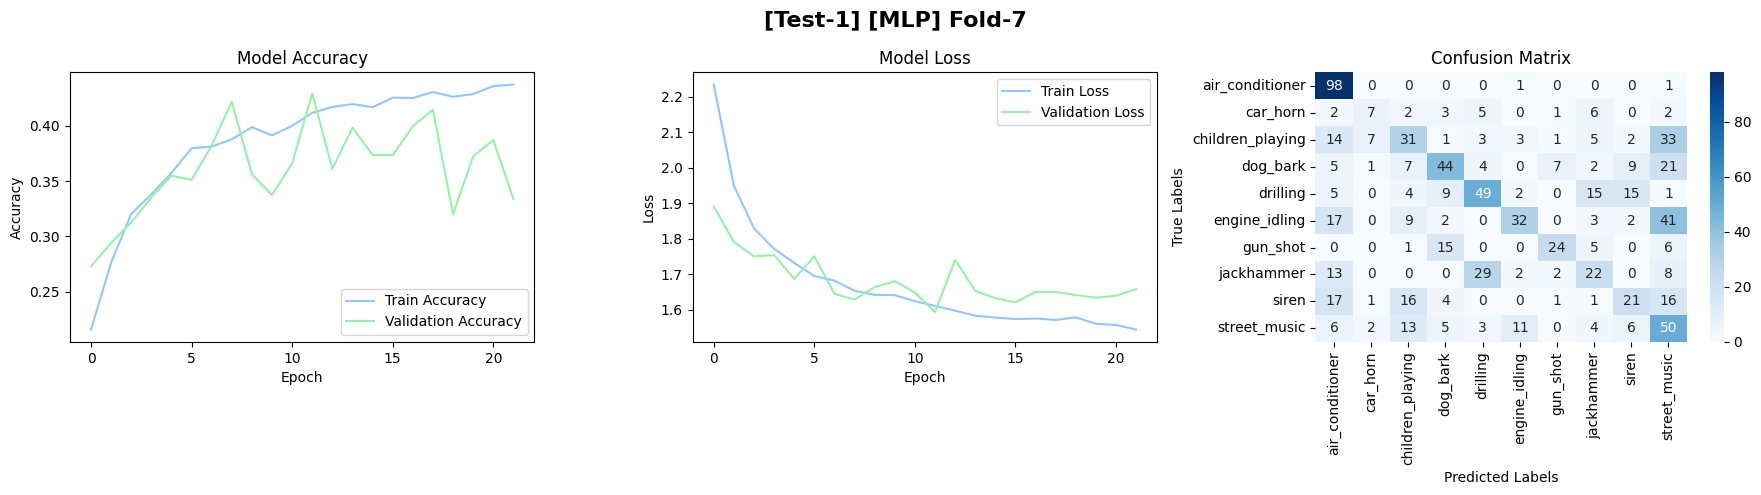

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


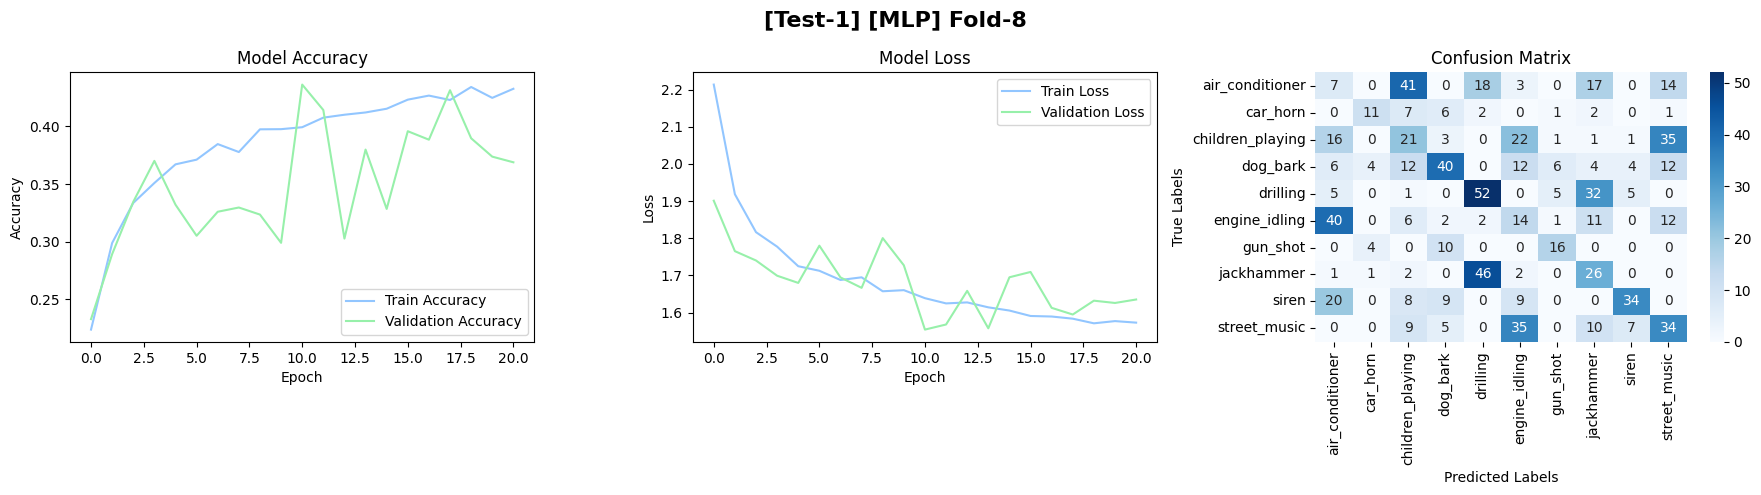

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


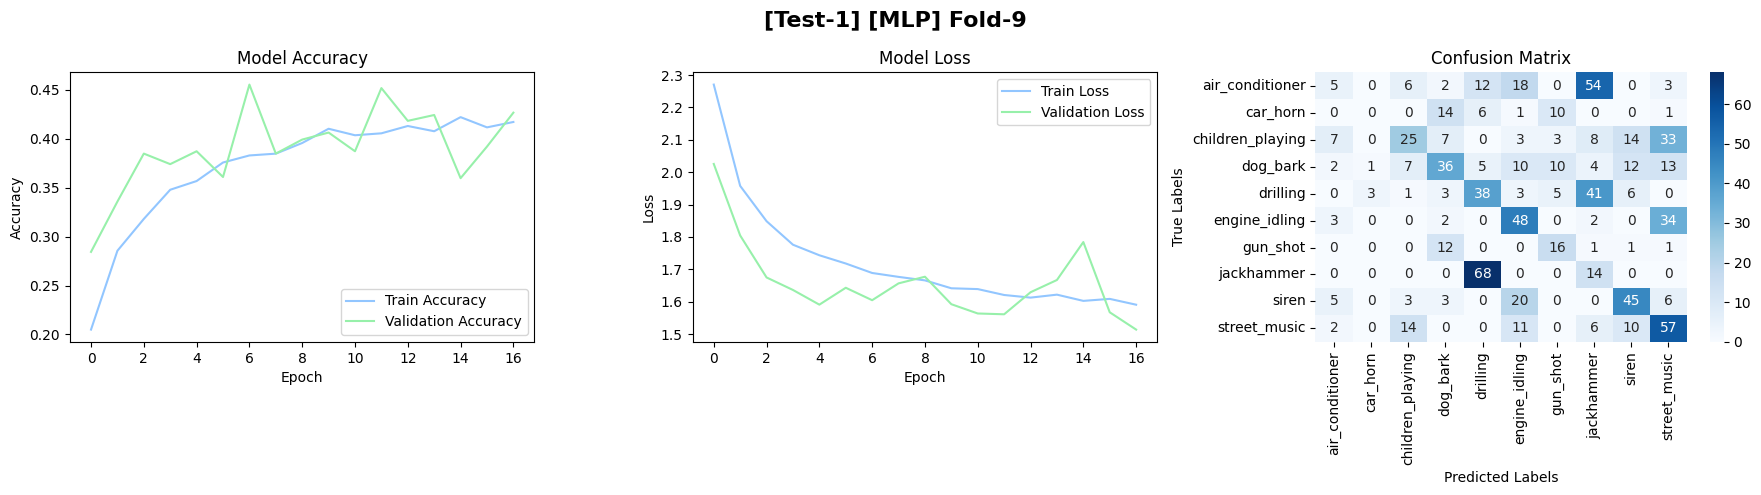

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


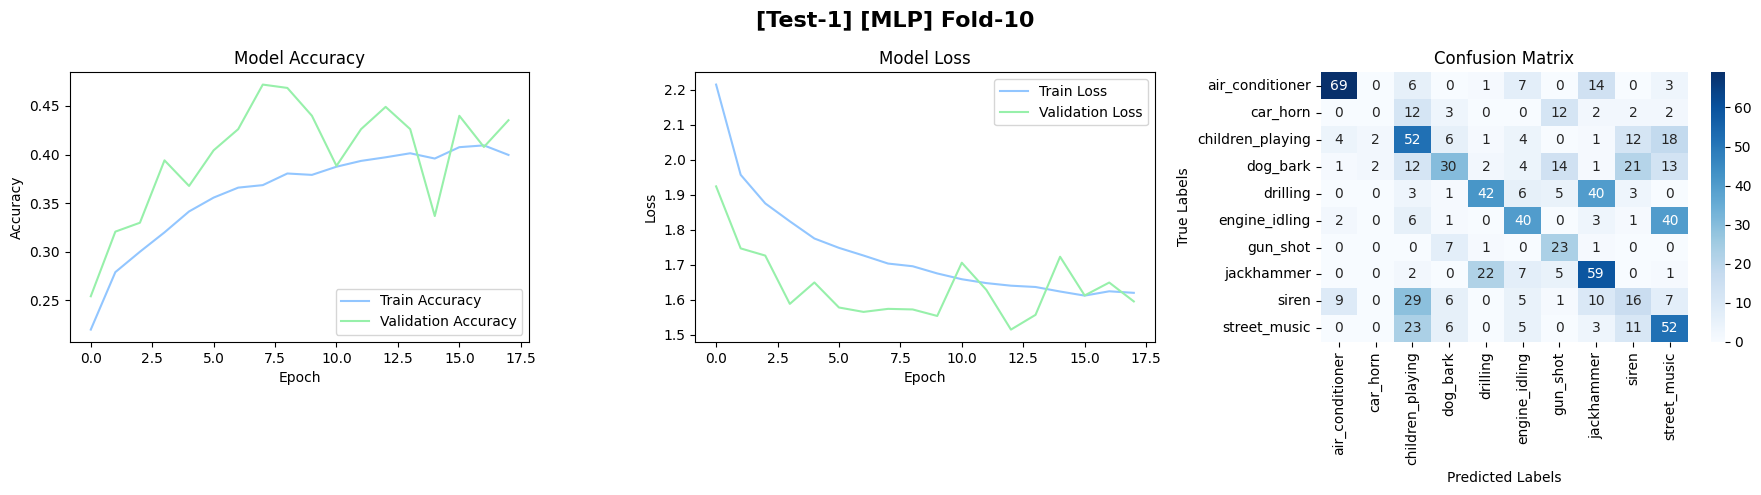

In [43]:
# Perform Cross Validation
histories, confusionMatrices = mlpDataManager.crossValidate(createModel=createMLP, epochs=50, callbacks=callbacks)

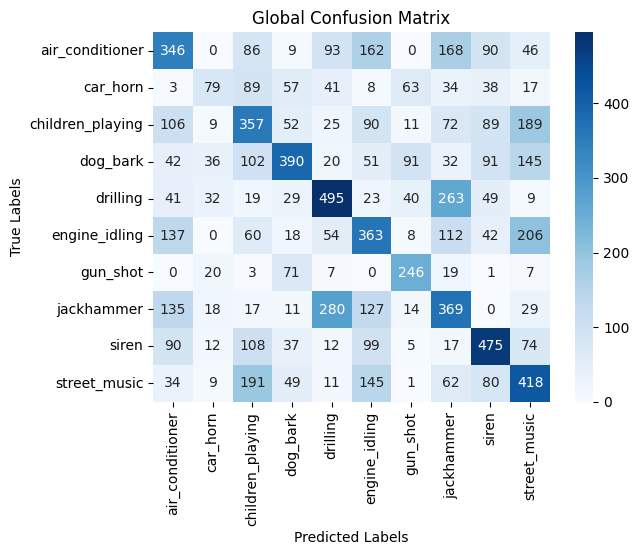

In [42]:
# Plot the Global Confusion Matrix
mlpDataManager.plotGlobalConfusionMatrix(confusionMatrices)

---
### Convolutional Neural Network (CNN)
---

> DEFINE THE NETWORK ARCHITECTURE

In [ ]:
# Load the Dataset with the 2-Dimensional Extracted Data
cnnDataManager = UrbanSound8kManager(dataDimensionality='2D', modelType="CNN", testNumber=1, pathsConfig=pathsConfig)

In [ ]:
def createCNN():
    # Create a instance of a CNN
    cnn = CNN()
    # model = cnn.create1DCNN(input_shape=(459, 1))
    cnnModel = cnn.create2DCNN(input_shape=(13, 345, 1))

    # Define the learning rate to use
    lr = 0.001
    
    # Define the Optimizer
    optimizer = Adam(learning_rate=lr)
    
    # Compile the Model
    cnnModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the Compiled Model
    return cnnModel

In [ ]:
# Create a instance of the CNN Model and inspect its architecture
cnnModel = createCNN()
cnnModel.summary()

In [ ]:
# keras.utils.plot_model(model, "model.png", show_shapes=True, show_layer_activations=True, rankdir='TB', expand_nested=False)

In [ ]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]

In [ ]:
# Perform Cross Validation
histories, confusionMatrices = cnnDataManager.crossValidate(createModel=createCNN, epochs=50, callbacks=callbacks)

In [ ]:
# Plot the Global Confusion Matrix
cnnDataManager.plotGlobalConfusionMatrix(confusionMatrices)

---
### YAMNET (Pretrained CNN)
---

> TALK ABOUT THE YAMNET AND HOW WE WANT TO USE IT IN A TRANSFER LEARNING SETTING TO OBTAIN BETTER RESULTS

In [ ]:
# YAMNET Details @ https://www.tensorflow.org/hub/tutorials/yamnet?hl=pt-br

In [ ]:
# Load the Dataset with the 1-Dimensional Extracted Data
yamnetDataManager = UrbanSound8kManager(dataDimensionality='1D', modelType="YAMNET", testNumber=1, pathsConfig=pathsConfig)

In [ ]:
def createYAMNET():
    # Create a instance of the network
    yamnet = createTransferLearning()

    # Define the learning rate to use
    lr = 0.001
    
    # Define the Optimizer
    optimizer = Adam(learning_rate=lr)
    
    # Compile the model
    yamnet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Return Compiled Model
    return yamnet

In [ ]:
# Create a instance of the MLP and inspect its architecture
yamnet = createYAMNET()
yamnet.summary()

In [ ]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]

In [ ]:
# Perform Cross Validation
histories, confusionMatrices = yamnetDataManager.crossValidate(createModel=createYAMNET, epochs=50, callbacks=callbacks)

In [ ]:
# Plot the Global Confusion Matrix
yamnetDataManager.plotGlobalConfusionMatrix(confusionMatrices)

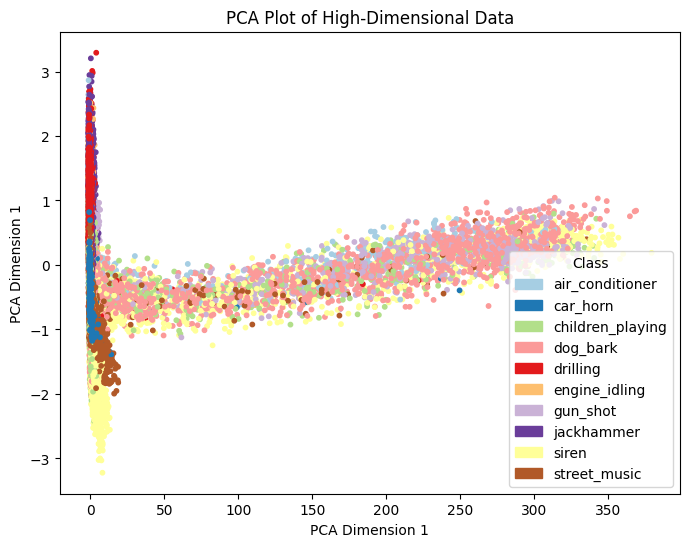

In [ ]:
X, targets = yamnetDataManager.getAllFolds()
plotScatterClass(X, targets)
del X, targets

---
### Residual Network (ResNet)
---

> DEFINE THE NETWORK ARCHITECTURE

In [55]:
# Load the Dataset with the 1-Dimensional Extracted Data
resNetDataManager = UrbanSound8kManager(dataDimensionality='2D', modelType="ResNet", testNumber=1, pathsConfig=pathsConfig)

In [56]:
def createResNet():
    # Create a instance of the network
    resNet = ResNet(input_shape=(13, 345,1))
    resNetModel = resNet.createResNet()
    
    # Define the learning rate to use
    lr = 0.001
    
    # Define the Optimizer
    optimizer = Adam(learning_rate=lr)
    
    # Compile the model
    resNetModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Return Compiled Model
    return resNetModel

In [57]:
# Create a instance of the MLP and inspect its architecture
resNet = createResNet()
resNet.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_134 (Conv2D)                  │ (None, 7, 173, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_134              │ (None, 7, 173, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_119 (ReLU)                     │ (None, 7, 173, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 87, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_50 (Sequential)           │ (None, 4, 87, 64)           │         148,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_51 (Sequential)           │ (None, 1, 22, 128)          │         527,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_52 (Sequential)           │ (None, 1, 6, 256)           │       2,102,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_53 (Sequential)           │ (None, 1, 2, 512)           │       8,399,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,186,890 (42.67 MB)

 Trainable params: 11,177,290 (42.64 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [58]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 141s 591ms/step - accuracy: 0.4101 - loss: 1.8989 - val_accuracy: 0.1824 - val_loss: 3.9344 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 137s 629ms/step - accuracy: 0.6173 - loss: 1.1019 - val_accuracy: 0.2624 - val_loss: 2.6635 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 130s 598ms/step - accuracy: 0.7066 - loss: 0.8651 - val_accuracy: 0.3795 - val_loss: 2.6742 - learning_rate: 0.0010
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 132s 607ms/step - accuracy: 0.7208 - loss: 0.8166 - val_accuracy: 0.4088 - val_loss: 2.4984 - learning_rate: 0.0010
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 128s 589ms/step - accuracy: 0.7664 - loss: 0.6941 - val_accuracy: 0.4550 - val_loss: 2.1343 - learning_rate: 0.0010
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 129s 594ms/step - accuracy: 0.7827 - loss: 0.6160 - val_accuracy: 0.3784 - val_loss: 3.0059 - learning_rate: 0.0010
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 139s 637ms/step - accura

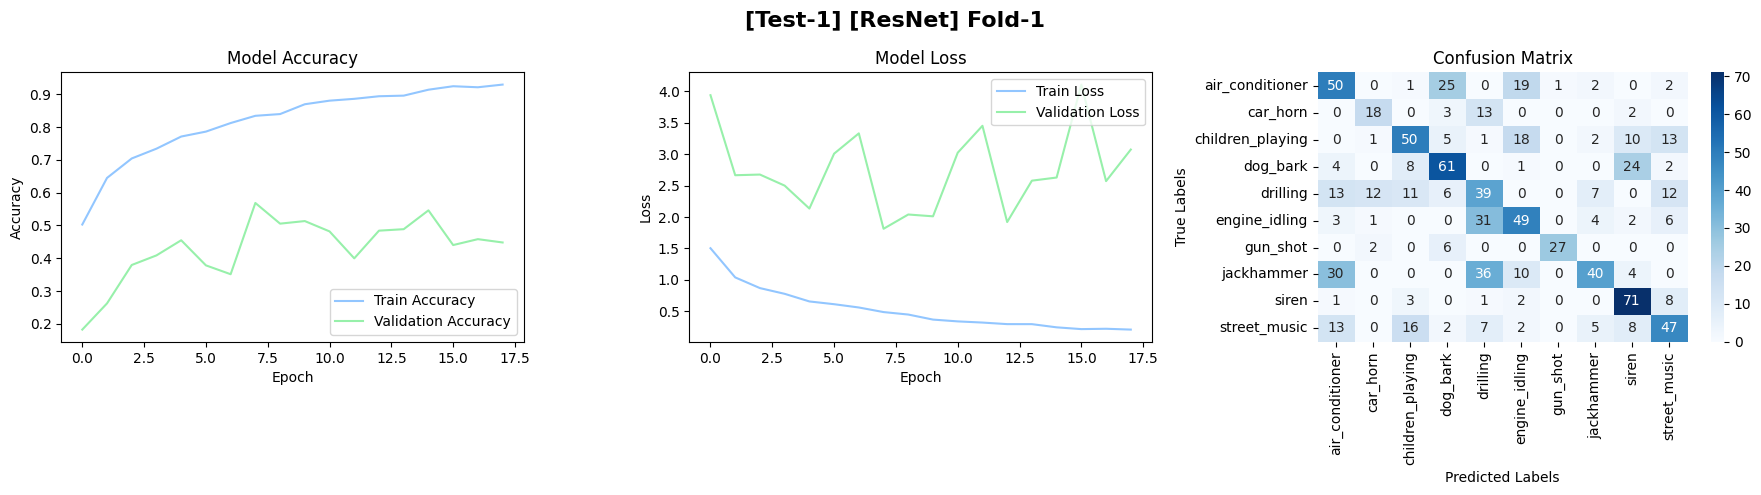

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 131s 548ms/step - accuracy: 0.3800 - loss: 1.9515 - val_accuracy: 0.1070 - val_loss: 4.7617 - learning_rate: 0.0010
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 117s 541ms/step - accuracy: 0.6090 - loss: 1.1467 - val_accuracy: 0.3751 - val_loss: 2.1507 - learning_rate: 0.0010
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 119s 546ms/step - accuracy: 0.6897 - loss: 0.9296 - val_accuracy: 0.3827 - val_loss: 2.6733 - learning_rate: 0.0010
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 118s 542ms/step - accuracy: 0.7367 - loss: 0.7876 - val_accuracy: 0.3719 - val_loss: 2.8929 - learning_rate: 0.0010
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 119s 550ms/step - accuracy: 0.7574 - loss: 0.7077 - val_accuracy: 0.4443 - val_loss: 1.9000 - learning_rate: 0.0010
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 117s 541ms/step - accuracy: 0.7788 - loss: 0.6396 - val_accuracy: 0.4670 - val_loss: 2.0477 - learning_rate: 0.0010
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 119s 550ms/step - accura

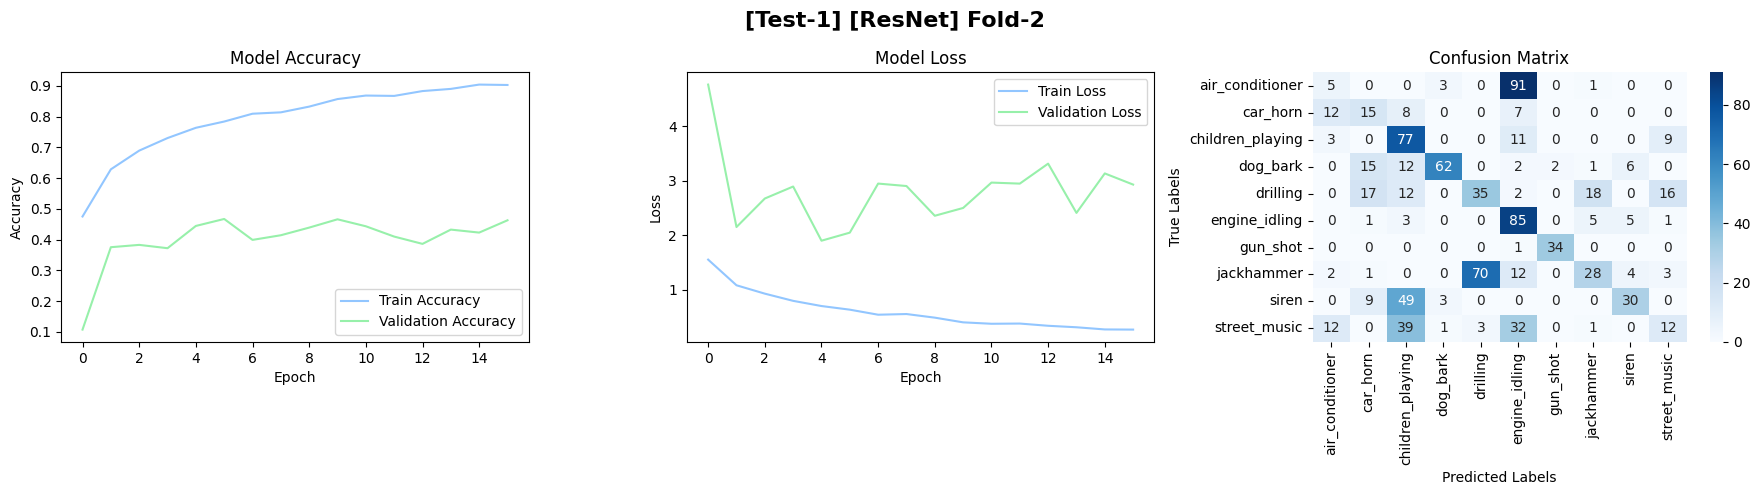

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 127s 547ms/step - accuracy: 0.3885 - loss: 1.9879 - val_accuracy: 0.1717 - val_loss: 3.3080 - learning_rate: 0.0010
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 117s 545ms/step - accuracy: 0.5908 - loss: 1.2126 - val_accuracy: 0.3828 - val_loss: 1.9992 - learning_rate: 0.0010
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 116s 542ms/step - accuracy: 0.6358 - loss: 1.0729 - val_accuracy: 0.4828 - val_loss: 1.7627 - learning_rate: 0.0010
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 117s 546ms/step - accuracy: 0.6890 - loss: 0.9175 - val_accuracy: 0.4869 - val_loss: 1.8494 - learning_rate: 0.0010
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 116s 542ms/step - accuracy: 0.7323 - loss: 0.7996 - val_accuracy: 0.5101 - val_loss: 1.9065 - learning_rate: 0.0010
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 116s 543ms/step - accuracy: 0.7363 - loss: 0.7861 - val_accuracy: 0.5475 - val_loss: 1.7166 - learning_rate: 0.0010
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 116s 540ms/step - accura

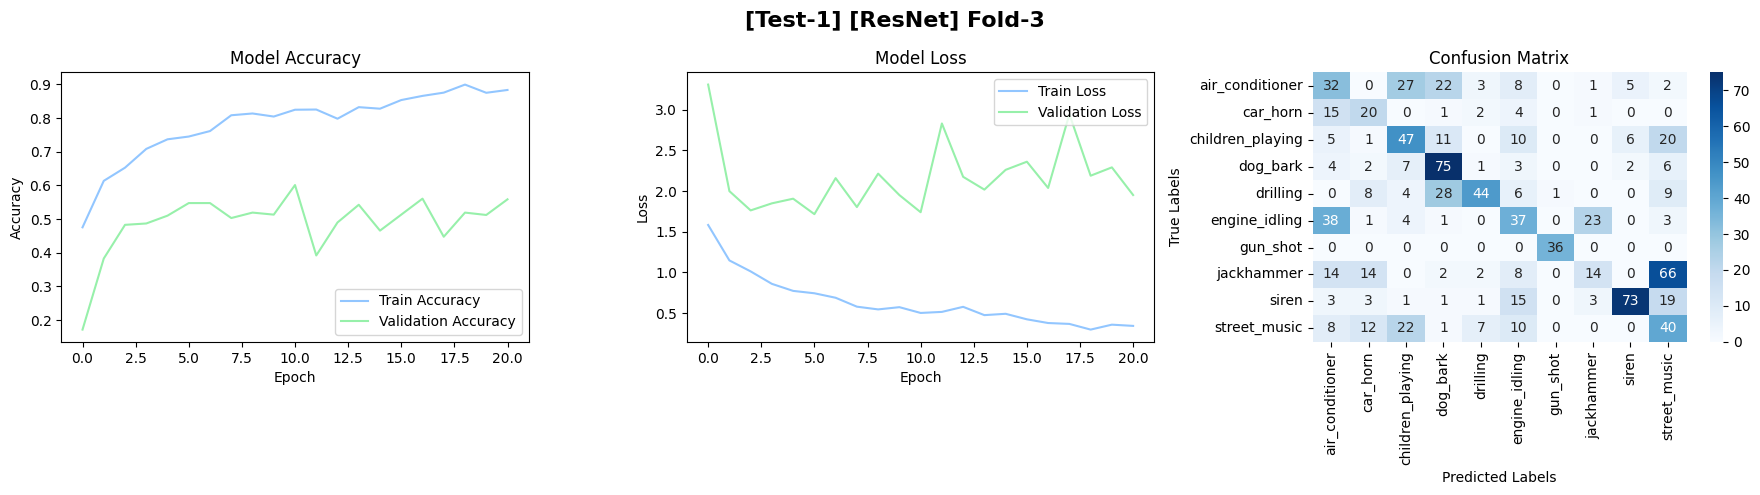

Epoch 1/50



KeyboardInterrupt



In [59]:
# Perform Cross Validation
histories, confusionMatrices = resNetDataManager.crossValidate(createModel=createResNet, epochs=50, callbacks=callbacks)

In [ ]:
# Plot the Global Confusion Matrix
resNetDataManager.plotGlobalConfusionMatrix(confusionMatrices)

<div align="center">
    
---
## Training Strategies
---

</div>

> ADD TRAINING STRATEGIES

In [ ]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Please ensure TensorFlow GPU version is installed.")
    
# Clear GPU cache
# tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

<div align="center">
    
---
## Performance Evaluation
---

</div>

> ADD PERFORMANCE EVALUATION

<div align="center">

***
## Bibliographic References
***
</div>

1. AUTHOR (DATE OF PUBLICATION). __*ARTICLE TITLE*__. Available [here](__INSERT_LINK__)

LINKS:
- https://medium.com/@MuhyEddin/feature-extraction-is-one-of-the-most-important-steps-in-developing-any-machine-learning-or-deep-94cf33a5dd46
- https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504
- https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

---
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`
    - [Pedro Afonseca](https://github.com/PsuperX) &#8594; `up202205394@edu.fc.up.pt`

---
---

<div align="center">

## TESTS

</div>

### NETWORKS

In [ ]:
# Define the model
model = Sequential([
    # layers.Dense(2048, activation='relu', input_shape=(config['N_MFCC'],)),
    layers.Dense(2048, activation='relu', input_shape=(1395, )),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(10, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model = ResNet(num_classes=10)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.2)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=5e-4,
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

In [ ]:
trainX.shape

In [ ]:
# Train the model
history = model.fit(
    trainX, trainY,
    # utrainX, utrainY,
    validation_data=(testX, testY),
    # validation_data=(utestX, utestY),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Plot the Model Training Performance
plotNetworkTrainingPerformance(history.history)

In [ ]:
# %pip install scikeras

# WARNING: se usarmos pipelines e crossValidate do sklearn trainX pode n caber na memoria e ai fica complicado :/

In [ ]:
def dataset2Dataframe(ds: tf.data.Dataset) -> pd.DataFrame:
    data = []

    # Loop through the dataset and convert each example
    for embedding, label, fold in ds:
        embedding = embedding.numpy()
        label = label.numpy().decode('utf-8')
        fold = fold.numpy()
        
        # Append the data as a dictionary to the list
        data.append({
            'embedding': embedding,
            'label': label,
            'fold': fold,
        })

    return pd.DataFrame(data)

from ModelDevelopmentAndEvaluation. transferLearning import createEmbeddings, createTransferLearning

embeddings = createEmbeddings(df)
model = createTransferLearning()

embeddings = dataset2Dataframe(embeddings)

# TODO: make this pretty

In [ ]:
from ModelDevelopmentAndEvaluation. transferLearning import createEmbeddingsFaster, createTransferLearning

embeddings = createEmbeddingsFaster(df)

In [ ]:
embeddings.to_pickle(pathsConfig["Datasets"]["transfer"])

---

In [ ]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")

In [ ]:
u = UrbanSound8kManager(dataDimensionality='2D', modelType="MLP", pathsConfig=pathsConfig)
X_train, y_train, X_val, y_val, X_test, y_test = u.getTrainTestSplitFold(testFold=10)

In [ ]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]

In [ ]:
model = ResNet()

model.build(input_shape=(None, 13, 345,1))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# Train the model
history = model.fit(
    tf.expand_dims(X_train, -1), y_train,
    validation_data=(tf.expand_dims(X_val, -1), y_val),
    batch_size=64,
    epochs=50,
    callbacks=callbacks()
)